# Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import math

In [2]:
from numba import jit

In [3]:
pi = np.pi

In [4]:
import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d, Ticker, Label, FixedTicker, HoverTool
from bokeh.layouts import gridplot, layout
import bokeh.palettes as palettes

import ipyvolume.bokeh
output_notebook()

Loading BokehJS ...

In [5]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

# Auxilliary functions

In [6]:
def Figure(*args, **kwargs):

    fig = figure(*args, **kwargs)
    fig.title.text_font_size = '14pt'
    fig.xaxis.axis_label_text_font_size = "14pt"
    fig.yaxis.axis_label_text_font_size = "14pt"
    fig.xaxis.major_label_text_font_size = "14pt"
    fig.yaxis.major_label_text_font_size = "14pt"
    
    return fig

In [7]:
def cart2sphe(x, y, z):
    r = np.sqrt(x*x+y*y+z*z)                      # radial coordinate
    theta = np.arccos(z/r)                        # co-latitude
    phi = np.arctan2(y,x)                         # longitude
    return r,theta,phi

In [8]:
def sphe2cart(r,theta,phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x,y,z

# Gaia data

In [55]:
Gaia = pd.read_csv("Data\Gaia_MW_nolowd.csv") # RR Lyrae sample zonder LMC/SMC en met distance > 0.5kpc
usedQuantities = ['Xg','Yg','Zg']
Gaia.dropna(subset=usedQuantities, inplace=True)

C:\Users\Sarah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (215,228) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
print("Number of stars in the GDR2 Milky Way sample: {0}".format(len(Gaia)))

Number of stars in the GDR2 Milky Way sample: 143103


In [12]:
x0, y0, z0 = Gaia['Xg'], Gaia['Yg'], Gaia['Zg']

In [13]:
hist, edges = np.histogram(x0, density=False, bins=200)

In [14]:
p = Figure(width=800, height=400, x_axis_label='x', y_axis_label='Count', toolbar_location="below")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)
show(p)

# Kernel definition in Python

In [15]:
@jit
def kernel(x, y, z, mux, muy, muz, sigmax, sigmay, sigmaz):
    C = 1 / (2*pi)**(3/2) / sigmax / sigmay / sigmaz
    return C * np.exp(-0.5 * ((x-mux)**2/sigmax**2 + (y-muy)**2/sigmay**2 + (z-muz)**2/sigmaz**2))

In [16]:
@jit
def KDE(x, y, z, x0, y0, z0, sigmax, sigmay, sigmaz):
    result = np.zeros((len(x), len(y), len(z)))
    
    for n in range(len(x)):
        print(n)
        for k in range(len(y)):
            for j in range(len(z)):
                result[n,k,j] = np.sum(kernel(x[n], y[k], z[j], x0, y0, z0, sigmax, sigmay, sigmaz)) / len(x0)
                
    return result

In [17]:
@jit
def KDE2(x, y, z, x0, y0, z0, sigmax, sigmay, sigmaz):
    result = np.zeros((len(x), len(y), len(z)))
    
    for n in range(len(x)):
        print(n)
        for k in range(len(y)):
            for j in range(len(z)):
                result[n,k,j] = np.sum(kernel(x[n], y[k], z[j], x0, y0, z0, sigmax[n,k,j], sigmay[n,k,j], sigmaz[n,k,j])) / len(x0)
                
    return result

## Grid points

In [18]:
x = np.linspace(x0.min()*1.1, x0.max()*1.1, 100)
y = np.linspace(y0.min()*1.1, y0.max()*1.1, 100)
z = np.linspace(z0.min()*1.1, z0.max()*1.1, 100)

In [47]:
sigmax = (x0.max() - x0.min()) / 100
sigmay = (y0.max() - y0.min()) / 100
sigmaz = (z0.max() - z0.min()) / 100
print(sigmax,sigmay,sigmaz)

1.77755386624 1.95993269262 2.20071696142


## Result 1: constant bandwidth

In [74]:
%time result1 = KDE(x, y, z, x0, y0, z0, sigmax, sigmay, sigmaz)

CPU times: user 11h 40min 21s, sys: 15min 43s, total: 11h 56min 5s
Wall time: 2h 59min 23s


## Result 2: adaptive bandwidth at sample points

In [163]:
from scipy.interpolate import RegularGridInterpolator
fn = RegularGridInterpolator((x, y, z), result1)

In [164]:
@jit
def bandwidth():
    sigmax2 = np.zeros(len(x0))
    sigmay2 = np.zeros(len(x0))
    sigmaz2 = np.zeros(len(x0))
    for i in range(len(x0)):
        sigmax2[i] = sigmax/np.sqrt(fn((x0[i],y0[i],z0[i])))
        sigmay2[i] = sigmay/np.sqrt(fn((x0[i],y0[i],z0[i])))
        sigmaz2[i] = sigmaz/np.sqrt(fn((x0[i],y0[i],z0[i])))
        
    return sigmax2, sigmay2, sigmaz2

sigmax2, sigmay2, sigmaz2 = bandwidth()

In [165]:
%time result2 = KDE(x, y, z, x0, y0, z0, sigmax2, sigmay2, sigmaz2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 5h 44min 3s, sys: 13min, total: 5h 57min 3s
Wall time: 1h 29min 32s


## Result 3: adaptive bandwidth at grid points

In [167]:
sigmax3 = sigmax/np.sqrt(result1)
sigmay3 = sigmay/np.sqrt(result1)
sigmaz3 = sigmaz/np.sqrt(result1)

/home/sarahg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/sarahg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/sarahg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [168]:
%time result3 = KDE2(x, y, z, x0, y0, z0, sigmax3, sigmay3, sigmaz3)

0


/home/sarahg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in double_scalars
  """Entry point for launching an IPython kernel.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 5h 16min 45s, sys: 13min 31s, total: 5h 30min 17s
Wall time: 1h 22min 49s


### Save results

In [75]:
with open('Gaia_3dgauss_result1.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(result1.shape))
    for data_slice in result1:
        np.savetxt(outfile, data_slice)
        outfile.write('# New slice\n')

In [166]:
with open('Gaia_3dgauss_result2.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(result2.shape))
    for data_slice in result2:
        np.savetxt(outfile, data_slice)
        outfile.write('# New slice\n')

In [169]:
with open('Gaia_3dgauss_result3.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(result3.shape))
    for data_slice in result3:
        np.savetxt(outfile, data_slice)
        outfile.write('# New slice\n')

# Visualizing cross sections

## 2D cross sections

In [45]:
result = result1

In [24]:
X, Y = np.meshgrid(x, y, indexing='ij')
#X, Z = np.meshgrid(x, z, indexing='ij')
#Y, Z = np.meshgrid(y, z, indexing='ij')

-69.352915515


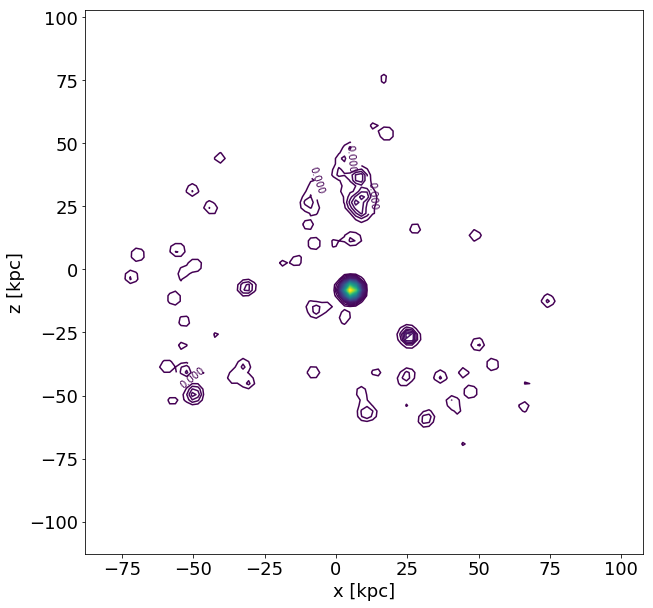

In [54]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))

levels = np.linspace(result[:,:,20].min(), result[:,:,20].max(), 100)
contours = plt.contour(X, Y, result[:,:,20], levels=levels)
#contours = plt.contour(X, Z, result[:,0,:], levels=levels)
#contours = plt.contour(Y, Z, result[50,:,:], levels=levels)

plt.xlabel('x [kpc]')
plt.ylabel("z [kpc]")
plt.clabel(contours, inline=1, fontsize=10)
print(z[20])

In [26]:
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
zmin, zmax = z.min(), z.max()

In [27]:
p = Figure(width=850, height=500, x_range=[xmin, xmax], y_range=[ymin, ymax], x_axis_label="x [kpc]", y_axis_label="y [kpc]")
p.image(image=[result[:,:,50].T], x=xmin, y=ymin, dw=xmax, dh=ymax, palette="Viridis11")
show(p)

## 1D Cross sections

In [28]:
p = Figure(width=850, height=500, x_axis_label="x [kpc]", y_axis_label="KDE")

iy, iz = 20, 10
ylabel = int(np.round(y[iy]))
zlabel = int(np.round(z[iz]))
p.line(x, result[:,iy,iz],line_width=2, line_color="blue", legend="(y,z)=({0},{1})".format(ylabel,zlabel))

iy, iz = 50, 40
ylabel = int(np.round(y[iy]))
zlabel = int(np.round(z[iz]))
p.line(x, result[:,iy,iz],line_width=2, line_color="red", legend="(y,z)=({0},{1})".format(ylabel,zlabel))

iy, iz = 60, 90
ylabel = int(np.round(y[iy]))
zlabel = int(np.round(z[iz]))
p.line(x, result[:,iy,iz],line_width=2, line_color="green", legend="(y,z)=({0},{1})".format(ylabel,zlabel))

show(p)

In [46]:
p = Figure(width=850, height=500, x_axis_label="y [kpc]", y_axis_label="KDE")

selection = (x0 > -10) & (x0 < -8) & (z0 > 70) & (z0 < 80)
hist, edges = np.histogram(x0[selection], density=False, bins=200)
#p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)

ix, iz = 30, 80
xlabel = int(np.round(x[ix]))
zlabel = int(np.round(z[iz]))
#p.line(y, result[ix,:,iz],line_width=2, line_color="blue", legend="(x,z)=({0},{1})".format(xlabel,zlabel))

ix, iz = 40, 80
xlabel = int(np.round(x[ix]))
zlabel = int(np.round(z[iz]))
p.line(y, result[ix,:,iz]/result.max()*hist.max(),line_width=2, line_color="red", legend="(x,z)=({0},{1})".format(xlabel,zlabel))

ix, iz = 80, 80
xlabel = int(np.round(x[ix]))
zlabel = int(np.round(z[iz]))
#p.line(y, result[ix,:,iz],line_width=2, line_color="green", legend="(x,z)=({0},{1})".format(xlabel,zlabel))

show(p)

In [30]:
p = Figure(width=850, height=500, x_axis_label="z [kpc]", y_axis_label="KDE")

ix, iy = 20, 50
xlabel = int(np.round(x[ix]))
ylabel = int(np.round(y[iy]))
p.line(z, result[ix,iy,:],line_width=2, line_color="blue", legend="(x,y)=({0},{1})".format(xlabel,ylabel))

ix, iy = 40, 50
xlabel = int(np.round(x[ix]))
ylabel = int(np.round(y[iy]))
p.line(z, result[ix,iy,:],line_width=2, line_color="red", legend="(x,y)=({0},{1})".format(xlabel,ylabel))

ix, iy = 60, 50
xlabel = int(np.round(x[ix]))
ylabel = int(np.round(y[iy]))
p.line(z, result[ix,iy,:],line_width=2, line_color="green", legend="(x,y)=({0},{1})".format(xlabel,ylabel))

show(p)

### 1D plots to compare with histograms

In [31]:
@jit
def distance(result):
    dx = np.zeros(len(x))
    dy = np.zeros(len(y))
    dz = np.zeros(len(z))
    for i in range(len(x)):
        dx[i] = np.nansum(result[i,:,:])#/len(x)
        dy[i] = np.nansum(result[:,i,:])#/len(y)
        dz[i] = np.nansum(result[:,:,i])#/len(z)
    return dx, dy, dz           

In [32]:
def gauss(x, c, mu, sig):
    return c /(sig * np.sqrt(2*pi)) * np.exp(-(x - mu)**2 / (2 * sig**2))

In [48]:
p = Figure(width=850, height=500, x_axis_label="x [kpc]", y_axis_label="KDE")

dx1,dy1,dz1 = distance(result1)
dx3,dy3,dz3 = distance(result3)

hist, edges = np.histogram(x0, density=False, bins=200)
p.quad(top=hist/hist.max()*dx1.max(), bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)

p.line(x, dx1, line_color="green",line_width=2)
p.line(x, dx3/dx3.max()*dx1.max(), line_color="red",line_width=2)
show(p)

In [34]:
p = Figure(width=850, height=500, x_axis_label="y [kpc]", y_axis_label="KDE")
hist, edges = np.histogram(y0, density=False, bins=200)
p.quad(top=hist/hist.max()*dy1.max()*0.8, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)

p.line(y, dy1, line_color="green",line_width=2)
p.line(y, dy3/dy3.max()*dy1.max(), line_color="red",line_width=2)
show(p)

In [35]:
p = Figure(width=850, height=500, x_axis_label="z [kpc]", y_axis_label="KDE")
hist, edges = np.histogram(z0, density=False, bins=200)
p.quad(top=hist/hist.max()*dz1.max()*0.8, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)

p.line(z, dz1, line_color="green",line_width=2)
p.line(z, dz3/dz3.max()*dz1.max(), line_color="red",line_width=2)
show(p)